# A/B Tests for Engineers

## Introduction

I'd like to discuss a simple variation of [A/B testing](https://en.wikipedia.org/wiki/A/B_testing) in an engineering style.

By "an engineering style" I mean:

  * We will work a simulated example to see that the system works as claimed.
  * We will exhibit examples of problems before trying to fix them.
  * We will demonstrate all of the top level claims as calculations, and not delegate these to references.
  * We will leave fundamental math to the references, and not try to re-derive it.

In my opinion far too few A/B testing treatments check soundness, even on simulated data. This makes it easy for such articles to leave out important steps. If a relied on reference omits a step, the derived work may have to do the same.

We will implement the experiment design directly, instead of using a canned power calculator so we have a place to discuss some of the design issues in A/B test design.

## Set Up

A common A/B test of interest is measuring a difference in rates. We have one system that for each example does what we want with with probability `P[A]` (`P[A]` not known, to be estimated) and another that does what we want with probability `P[B]` (`P[B]` not known, to be estimated). We want to know if `P[B] - P[A] >= t` for a threshold `t >= 0`. That is: is "B"'s conversion rate a substantial improvement over "A"'s conversion rate?

Let's extend this to an example and simulation.

Suppose we have two shopping cart check-out interfaces, and a stream of *non-recurring* visitors. We are testing variations in the user interface late in an online shopping checkout process. Perhaps we are testing how items are reported, payment is specified, or so on. We are interested in shopping cart completion rate as a function of how we interact with the user. We have our current system which we all "A" (or "control" or "champion"), and we have our new process which we call "B" (or "treatment" or "challenger").

We ask: how many samples do we need to, with high confidence, confirm if "B" is or is not a big improvement compared to "A"?

Our experiment is to collect `2 * n` example checkouts, and assign `n` of them to `A` at random and `n` of them to `B` at random. Random assignment is used so we are studying the difference between A and B, and not accidentally studying the assignment process. We say "B" appears better than "A" if the observed `mean(B) - mean(A) >= t` for a chosen threshold `t >= 0`.

The user specifies three parameters that determine the A/B test:

  * `r`: their definition of "large improvement." This is how large a change in success probability we consider big. We say "B" *is* much better than "A" if `P[B] - P[A] >= r`. Our test determination is "B" *appears* much better than "A" if `mean(B) - mean(A) >= t`. Typically a reliable test has `0 < t < r`.
  * `significance`: the desired [false positive](https://en.wikipedia.org/wiki/False_positives_and_false_negatives) rate or test significance. This is how often we are willing to accept an incorrect indication of "big improvement" when there is in fact no improvement.
  * `power`: the desired [true positive](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) rate or test sensitivity. This is how often we hope to correctly recognize large improvements.

Given the above parameters we then select:

  * `t`: the threshold to say whether `observe_mean(B) - observed_mean(A) >= t` is considered strong positive evidence.
  * `n`: the number of items to test from "A" and from "B".

If we select `n` and `t` correctly *and run the test properly*: then we have a reliable test that meets the `significance` and `power` requirements.

We are assuming we are in one of two worlds. One world is the "null hypothesis H0" or "A/A" world where the "B" process is exactly the "A" process. The other is the "big improvement world H1" where `P[B completes] - P[A completes] >= r`. We can design a test procedure that is correct in both worlds, and then use that to determine which world we are likely in.

**In my opinion, it is a common mistake or omission to think `t = r`.** We set up this note to discuss exactly this point. Some power calculators apparently do not even return `t`, fueling this confusion (and leaving the calculation to the user). This error is *not* present in the primary literature (such as Cohen, *Statistical Power Analysis for the Behavioral Sciences*, 2nd Edition, 1988, Lawrence Erlbaum Associates), but the omission is routinely introduced and replicated in the data science "how to" echo chamber.

If one doesn't look at the software defaults, `significance` and `power` are often set at standard (unjustified or not domain specific) default values `significance = 0.05`, `power = 0.8`. In my opinion it is a bad choice to leave these parameters at such defaults.

   * `significance` should be moved closer to `0` if one is testing many things and one wants to defend against the [multiple comparison problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). The multiple comparisons problem is essentially the unreliability of a the process of testing again and again until you get a "yes." 
   * `power` should be moved closer to `1` if you don't feel good about throwing out 20% of large improvement "B"s!

If one is using a 2-sided test, where both "A" or "B" are novel alternatives, and either one could be better, then one should halve `significance` as a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction).

### An example

Let's continue our example in Python.

In [1]:
# import our packages
import numpy as np
from scipy.stats import norm
from IPython.display import Code, display, Image
from stat_tools import (
    find_threshold_adjustment, 
    find_n_for_given_mass_of_binomial_left_of_threshold, 
    norm_cdf_inverse
)
import sympy

# prepare our pseudo-random number generator
rng = np.random.default_rng(2023)

# get our plotnine plotting fn
from sig_pow_visual import binomial_diff_sig_pow_visual

Suppose we specify:

  * `r = 0.1` (meaning we are interested in a 10% absolute improvement in conversion rates).
  * `significance = 0.02` (meaning we are allowing a 2% [false positive](https://en.wikipedia.org/wiki/False_positives_and_false_negatives) rate)
  * `power = 0.9` (meaning we want a 90% [true positive](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) rate, or sensitivity).

In [2]:
# specify our user parameters
r = 0.1
significance = 0.02
power = 0.9
assert (r > 0) and (r < 1)
assert (significance > 0) and (significance < 0.5)
assert (power > 0.5) and (power < 1)

## In practice (with no guidance)

In practice we have two sources of data: A and B. We want to know if they are truly different in behavior from observed outcomes.

Let's set this up as an example. Suppose our A source simulation is defined as follows.

In [3]:
# define our stand in experiments
def a_completed() -> float:
    "Simulate an event that is 1 47% of the time, and 0 otherwise"
    return float(rng.binomial(n=1, p=0.47, size=1)[0])

And our B source simulation is defined as follows.

In [4]:
# define the B process
def b_completed() -> float:
    "Simulate an event that is 1 57% of the time, and 0 otherwise"
    return float(rng.binomial(n=1, p=0.57, size=1)[0])

In our example we have the luxury of reading the code to tell that A and B are in fact different. In the real world we don't know if A and B are different, which is why would run an experiment.

With the simulated data sources in hand, we can simulate an experiment. We do this by calling an "A"-function and a "B"-function each `n` times and computing the observed average difference. Example code for that is below.

In [5]:
# simulate estimating the difference in means
def estimate_empirical_mean_difference(
        *,
        a_source, 
        b_source,
        ) -> float:
    """
    Estimate mean(b_source) - mean(a_source) using n samples of each.

    :param a_source: list of a-measurements.
    :param b_source: list of b-measurements.

    :return: mean(b) - mean(a)
    """
    return np.mean(b_source) - np.mean(a_source)

In practice an actual A/B test is run by collecting data. We tend to plan multiple A/B tests on the same set-up, as combining all data into a single test is at least as powerful as multiple tests. However following up on presumed good results with an extra (and larger) test is a good practice.

That being said, running an A/B test looks like the following. Here is an example where we try 20 examples for each of A and B.

In [6]:

estimate_empirical_mean_difference(
    a_source=[a_completed() for i in range(20)],
    b_source=[b_completed() for i in range(20)],  # trying to detect if this is A or B from the returned result
)

-0.09999999999999998

Scary questions include: 

  * Was 20 the right number of samples? 
  * Is the observed result an interesting size from a practical point of view? This is called a [clinical significance](https://en.wikipedia.org/wiki/Clinical_significance), and is a domain specific question. For our example: is the change in conversion rate driving enough revenue to justify the change?
  * Is the observed result large enough to claim a reliable measurement? This is called a [statistical significance](https://en.wikipedia.org/wiki/Statistical_significance), and is a question of reliability.

The experiment can try to lie to us in two ways:

  * It can claim there is a large difference between A and B, when there is in fact is not one. This is called a false positive or significance failure.
  * It can claim there is no large difference between A and B, when there is in fact is one. This is called a false negative or power failure.

Let's look at some examples of such failures.

## The "no difference" case or A/A case

An interesting case to try is when "B" is no better than "A". This is controlling the significance or false positive rate of the experiment.

By using simulated data we get the luxury of running such experiments multiple times from known situations. This gives us the ability to evaluate the reliability of the claimed test or measurement procedure.

Let's run a small A/A test (what is called when "B" is known to be identical to "A"). The actual theoretical difference in means is `0`, but for small sample sizes the experiment often returns a different number than that!

In [7]:
# run a few super small (and therefore unreliable) experiment
[
    estimate_empirical_mean_difference(
        a_source=[a_completed() for i in range(20)],
        b_source=[a_completed() for i in range(20)],  # notice also A so both sources are the same
    )
    for i in range(10)
]

[-0.2,
 0.050000000000000044,
 0.050000000000000044,
 -0.19999999999999996,
 0.25,
 -0.2,
 -0.10000000000000003,
 -0.15000000000000002,
 -0.2,
 -0.19999999999999996]

Notice we got very different values for the 10 repetitions of the test. This is evidence the `n=20` used is too small a test size.

Again, in practice we usually only run one initial experiment. If we have more up-front experimentation budget, we run larger tests, not more tests on the same set up.

## First stab at test size.

Now, let's calculate how large an experiment we need so that we don't mistake a non-improved "B" as being much better than "A". 

Let's assume we have a function that, for a given test threshold, return the required experiment size (or number of items to send to each of A and B). This function lets us design an experiment as follows. Let's use this function, but deliberately make the mistake of setting `t = r`. 

*On the surface* this seems reasonable: if we are looking for 10% improvement in conversion rate we might think to use 10% as our threshold. We will see in a bit why this isn't quite what we really want.

In [8]:
# make our error
t = r

Note, the above experiment design error will not cause problems in the A/A case. It isn't until we try to detect a difference when there is one we see the problem.

In [9]:
# get the sample size for significance goal (while neglecting power)
n_sig_wrong = int(np.ceil(find_n_for_given_mass_of_binomial_left_of_threshold(
    mass=1-significance,
    threshold=t,
)))

n_sig_wrong


211

Now let's run our A/A experiment a large number of times to see how often the observed difference in means is above or below this threshold.

In [10]:
# how many times we will repeat our run
n_repeat_trials = 10000

In [11]:
false_positive_rate_1 = np.mean([
    estimate_empirical_mean_difference(
        a_source=[a_completed() for i in range(n_sig_wrong)],
        b_source=[a_completed() for i in range(n_sig_wrong)],  # notice also A so both sources are the same
    ) >= t
    for i in range(n_repeat_trials)])

assert np.abs(false_positive_rate_1 - significance) < 1e-2

false_positive_rate_1

0.018

This great, *from a significance standpoint*. The experiment was over the threshold only about 2% of the time as designed. It has the desired error rate of 2% on the task of rejecting non-improvements. Now let's see why the `t=r` setting is wrong for the `B != A` case.



#### Power failure

Let's see how often this experiment is above the decision threshold, when there is a difference to be detected. We want this to be large, as that is when the outcome correctly notices the improvement.

In [12]:
true_positive_rate_1 = np.mean([
    estimate_empirical_mean_difference(
        a_source=[a_completed() for i in range(n_sig_wrong)],
        b_source=[b_completed() for i in range(n_sig_wrong)],  # "B" different than "A"
    ) >= t
    for i in range(n_repeat_trials)])

asserted = False
try:
    assert np.abs(true_positive_rate_1 - power) < 1e-2
except AssertionError:
    asserted = True
    print(f"observed true_positive_rate_1 {true_positive_rate_1}, not where we hoped ({power})")
assert asserted  # we don't *want* this, but confirming it happens in this run

true_positive_rate_1

observed true_positive_rate_1 0.4827, not where we hoped (0.9)


0.4827

Notice the observed true positive rate (or sensitivity) came out near 0.5, not out our `power = 0.9` desire. This is a problem: it means we will throw away half of our improved B processes!

Let's look at this in graphical form.


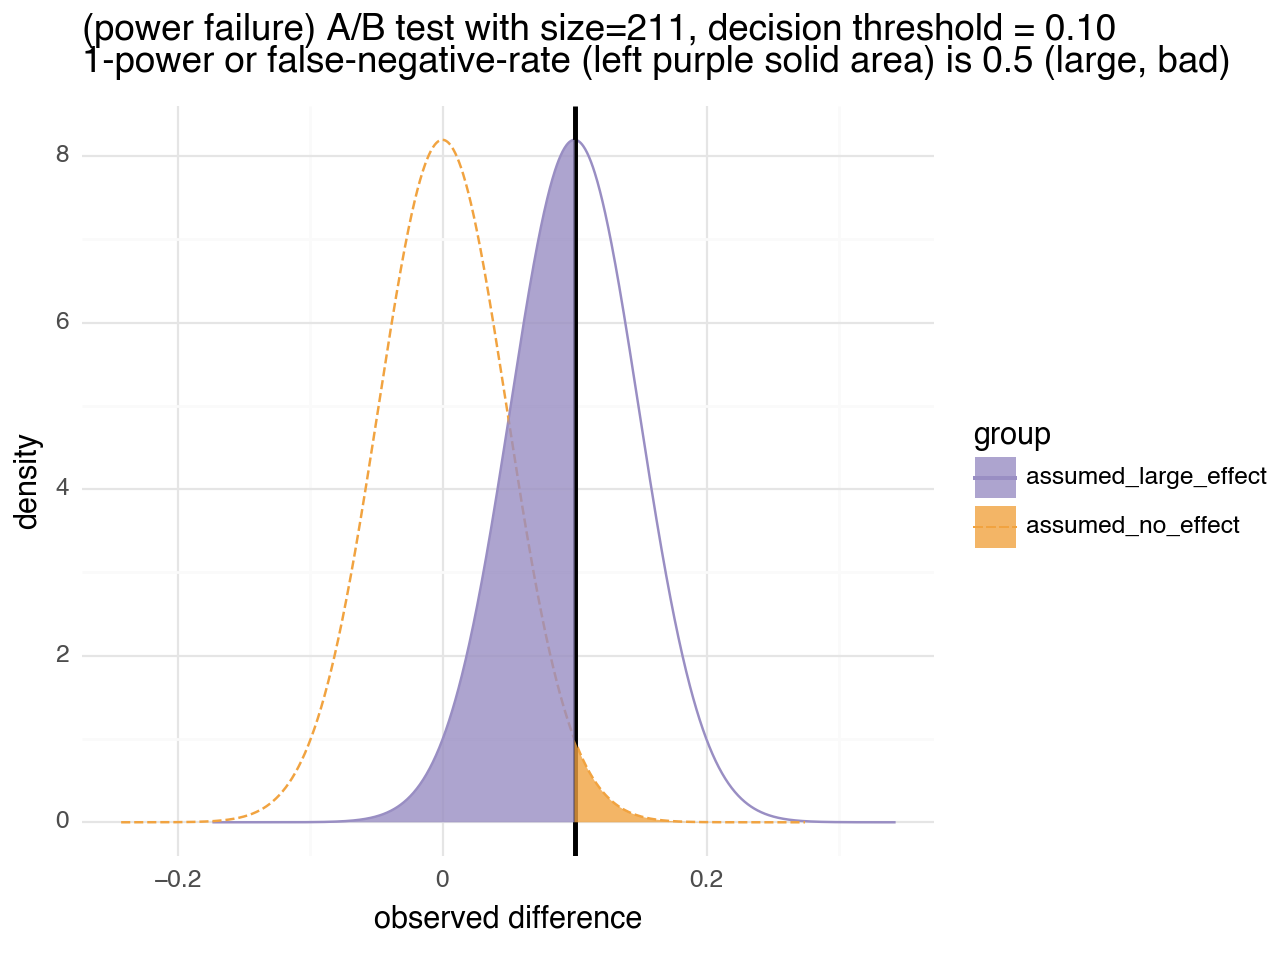

<Figure Size: (640 x 480)>

In [13]:
display(binomial_diff_sig_pow_visual(
  stdev=np.sqrt(0.5 / n_sig_wrong),
  effect_size=r, 
  threshold=r,
  title=f"(power failure) A/B test with size={n_sig_wrong}, decision threshold = {r:.2f}",
  subtitle="1-power or false-negative-rate (left purple solid area) is 0.5 (large, bad)"
  ))

All shaded areas in these graphs represent probability of experiment errors or failures. The left area represents `1 - power`, or the false negative rate. The right area represents `significance`, or the false positive rate. In good experiment design: both areas are simultaneously small.

The power failure is driven by two related causes:

  * Notice that nowhere in our experiment design did we use `power`, so why would we expect the experiment's sensitivity to land near `power`?
  * We are using the `t=r` mistake. The true difference between "A" and "B" is exactly `r` and the distribution is nearly symmetric. Thus we see experiment results above or below this value almost about half the time.

A large experiment of this type using `t=r` is pretty much guaranteed to experience an observed power or true positive rate near 1/2. 

One might hope the `t=r` "power mistake" is rare. Unfortunately, it seems to in fact be common. Consider the research summary: Cohen, J. "The statistical power of abnormal-social psychological research: A review" Journal of Abnormal and Social Psychology, 1962, 65, pp 145-153. This found "rather poor power, for example a mean of 0.48". That is disturbingly close to the power failure of `0.5`. This likely part of why Cohen wrote "Statistical Power Analysis for the Behavioral Sciences", which addresses the issue of "criterion" (what we are calling "decision threshold") as being a sample effect, *different from an assumed population effect*. However, I find many current tutorials fail to make this distinction and can lure the unwary into an implicit (even hidden) `t=r` power failure when mis-designing experiments.

#### Significance failure

We get a similar failure if we design the experiment only around power (instead of our previous only around significance). Now we will design for power or sensitivity: a 90% chance of getting a positive indication when `P(B) - P(A) >= t` (though we will intentionally neglect sensitivity for the moment).

In [14]:
# another wrong threshold
t = 0

In [15]:
# mass_to_right is 1-mass_to_left
n_power_wrong = int(np.ceil(find_n_for_given_mass_of_binomial_left_of_threshold(
    mass=power,
    threshold=r - t,
)))

n_power_wrong

83

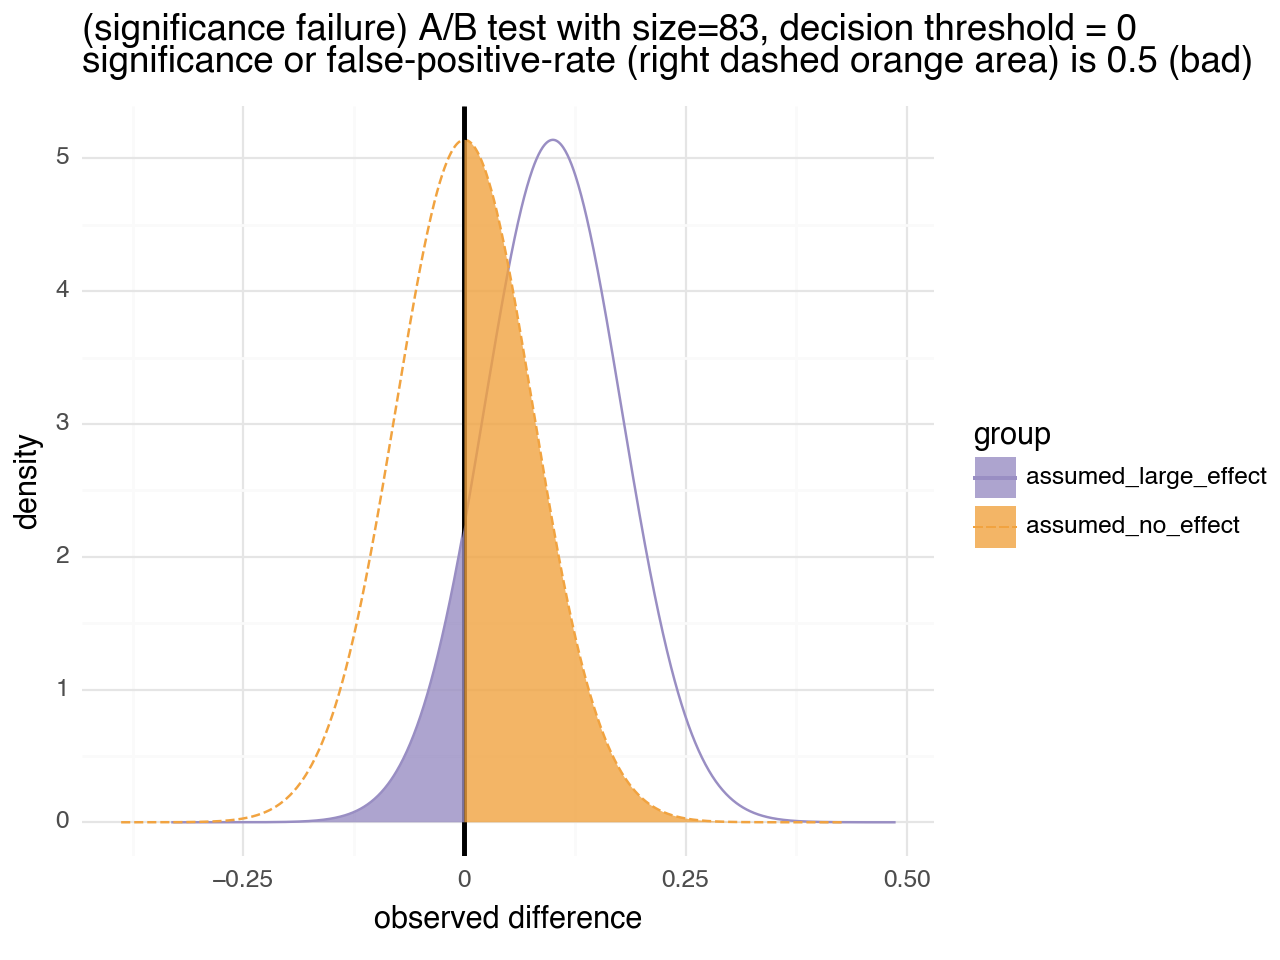

<Figure Size: (640 x 480)>

In [16]:
display(binomial_diff_sig_pow_visual(
  stdev=np.sqrt(0.5 / n_power_wrong), 
  effect_size=r, 
  threshold=0.0,
  title=f"(significance failure) A/B test with size={n_power_wrong}, decision threshold = 0",
  subtitle="significance or false-positive-rate (right dashed orange area) is 0.5 (bad)"
  ))


The above test has the flaw: it wrongly accepts the "A/A" case as "a substantial improvement" half the time!

One could say: "nobody is this careless." But, the above is exactly what happens under the (unfortunately) common practice of not using a decision threshold and saying any observed improvement is acceptable evidence of improvement.


### Designing a correct experiment


We hope we have made it clear that A/B testing with a threshold of either the assumed effect size or at zero is a mistake.

Let's find the correct test threshold.

We need to pick our test threshold `t` strictly in-between `0` and `r`. This is so we can simultaneously have a small false positive probability mass and a large true negative probability mass.

For a given `t` we need both:

  * `n >= find_n_for_given_mass_of_binomial_left_of_threshold(mass=1-significance, threshold=t)`  (`n` large enough to have a low false positive rate).
  * `n >= find_n_for_given_mass_of_binomial_left_of_threshold(mass=power, threshold=r - t)` (`n` large enough to have a high true positive rate).

For any `t` we pick `n` to satisfy both of these two criteria. We want to pick a `t` such that `n` is small (as `n` is how long we have to run the experiment).

In [17]:
# get the threshold adjustment
threshold_adjust = find_threshold_adjustment(
    power=power,
    significance=significance,
)

threshold_adjust


0.615761286067465

This says we should pick `t = 0.616 * r`, which we now do.

In [18]:
t =  r * threshold_adjust

t


0.06157612860674651

We leave the derivation of the threshold adjustment to an appendix.

For this threshold `t` we get a new `n` that meets both of the criteria.

In [19]:
n_sig = int(np.ceil(find_n_for_given_mass_of_binomial_left_of_threshold(
    mass=1 - significance,
    threshold=t,
)))

n_sig


557

In [20]:
n_power = int(np.ceil(find_n_for_given_mass_of_binomial_left_of_threshold(
    mass=power,
    threshold=r - t,
)))

n_power


557

In [21]:
assert n_sig == n_power

Notice we indeed get the same `n` for both conditions for this `t`.

In [22]:
n = int(np.max([n_sig, n_power]))
del n_sig   # make sure we don't accidentally use this going forward.
del n_power  # make sure we don't accidentally use this going forward.

Notice this new `n` is larger than the one we started with. This is because our new threshold is much smaller than the one we used before. And this in turn takes a larger `n` to reliably detect.

We now run the experiment with the new `t` and `n`.

In [23]:
false_positive_rate_2 = np.mean([
    estimate_empirical_mean_difference(
        a_source=[a_completed() for i in range(n)],
        b_source=[a_completed() for i in range(n)],  # notice also A so both sources are the same
    ) >= t
    for i in range(n_repeat_trials)])

assert np.abs(false_positive_rate_2 - significance) < 1e-2

false_positive_rate_2

0.0215

We see we still have the specified significance (or false positive rate) of about 2%.

In [24]:
true_positive_rate_2 = np.mean([
    estimate_empirical_mean_difference(
        a_source=[a_completed() for i in range(n)],
        b_source=[b_completed() for i in range(n)],  # B better than A
    ) >= t
    for i in range(n_repeat_trials)])

assert np.abs(true_positive_rate_2 - power) < 1e-2

true_positive_rate_2

0.8998


And we now see the specified power (also, sensitivity or true positive rate) of 90%.

Let's look at this in graphical form.

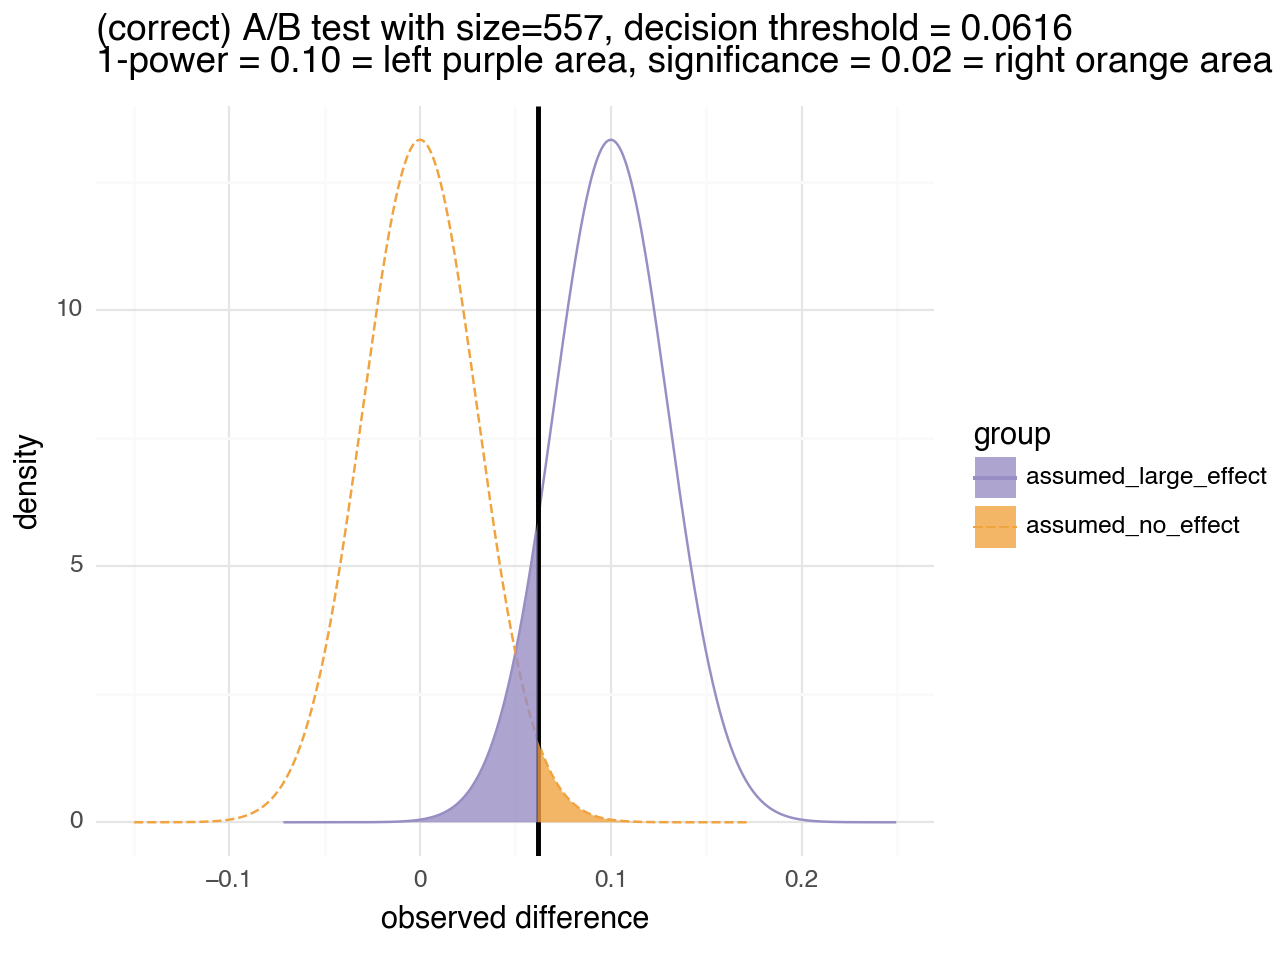

<Figure Size: (640 x 480)>

In [25]:
display(binomial_diff_sig_pow_visual(
  stdev=np.sqrt(0.5 / n), 
  effect_size=r, 
  threshold=t,
  title=f"(correct) A/B test with size={n}, decision threshold = {t:.4f}",
  subtitle=f"1-power = {1-power:.2f} = left purple area, significance = {significance:.2f} = right orange area"
))

We want the shaded regions to both be small, as their area represents the probability of different experiment failure modes.

## In practice again

On real A/B test application, we run once and need to trust that the math (and experiment design and discipline) guarantee the result is likely correct.

Let's run the test once.

In [26]:

a_data = [a_completed() for i in range(n)]
b_data = [b_completed() for i in range(n)]  # trying to detect if this is A or B from the returned result

experiment_result = estimate_empirical_mean_difference(
    a_source=a_data,
    b_source=b_data,
)

experiment_result

0.10053859964093353

We say "B" appears much better if the above result is at least `0.062`. Again, notice we are not using `0.1` (our intended definition of "large improvement") as our threshold. We are forced to reduce all the above work and measurements into a *decision* using a *decision threshold*.  That looks like the following.

In [27]:
think_B_is_much_better = experiment_result >= t

f"Think B is much better: {think_B_is_much_better}."

'Think B is much better: True.'

## Closing

We have demonstrated a simplified version of A/B testing from the ground up. This gives us the chance to get comfortable with the main characteristics of such tests: significance and power. It also lets us discuss an important detail of test design: how to translate the user's definition of "large difference" into a decision threshold.

Often an A/B test is not so much trying to find a large B, as it is trying to *confirm* if a given B is large or not. To respect or protect a given effect size for B, we must set the decision threshold below this effect size.

We have not discussed the importance of experimental hygiene and alignment with legitimate business goals. None of the math or engineering mentioned here *matters at all* if your test is not properly implemented or is testing something that does not matter. A good reference on the core issues of controlled experiments is Kohavi, Tang, Xu, *Trustworthy Online Controlled Experiments: A Practical Guide to A/B Testing*, Cambridge 2020.

I hope this leaves you in a good position ready to both experiment with the nature of A/B testing (on simulated data) and apply A/B testing to real world problems.

Thank you to Dr. Nina Zumel for her code and comments.

All the code for this note can be found [here](https://github.com/WinVector/Examples/tree/main/ab_test).

## Appendices

### Appendix: deriving the find `n` procedure

Our null hypothesis is that "B" is identical to "A". For large sample sizes `n`, the probability distribution of the above difference in sums is going to be very close to a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). This is due to the ["law of large numbers"](https://en.wikipedia.org/wiki/Law_of_large_numbers). Which normal distribution we use is completely determined by the mean and variance of the experiment.

Most statistical software has a function that given how many standard deviations out your observation tells you how rare that (or an even more extreme) event is. In general such a function is called "the inverse cumulative distribution function", and tells you how much of a what threshold places a given probability mass to the left of the threshold. In Python that function is `norm.ppf()`

For example in the mean-`0`, variance-`1` normal distribution about 99% of the numbers drawn are no more than `2.33`. Let's demonstrate this.

In [28]:
# draw a few examples of mean 0, variance 1 normally distributed numbers
rng.normal(size=5)

array([1.3628394 , 0.39827192, 0.08119358, 0.40168916, 1.20065715])

In [29]:
# show the threshold that about 99% of the draws we be no larger than
norm_99 = norm.ppf(0.99)

norm_99

2.3263478740408408

In [30]:
# confirm the 99% rareness empirically.
m0 = np.mean(rng.normal(size=10000000) <= norm_99)
assert np.abs(m0 - 0.99) < 1e-3

m0

0.9899827

It isn't important how complicated `norm.ppf()` is, as it is already implemented for us.

What comes next only becomes comfortable, once it is familiar. Trying a few more examples as we did with `rng.normal()` can help get "one's sea legs." It isn't so much that we are proving things, but we are linking things we want to establish to what are considered standard results. For the first timer: it feels like relating things we care about (but don't believe) to things we don't yet care about (and also may not yet believe). In fact we are trying to relate our claims, that are domain specific or application oriented, to claims that are considered somewhat more fundamental.

That being said, lets derive the expressions that are going into our A/B and A/A test planning code.

For our A/A example we want a threshold such that things that look similar with at least a `1-significance` probability (given the are in fact the same). This is because in the A/A case things *are* similar, the probability of getting a similar determination is also the probability of getting a correct determination.  

Under this "null hypothesis": the expected value of `estimate_empirical_mean_difference()` is zero, and the variance is `sqrt((p1 * (1-p1) + p2 * (1-p2))/ n)` (from the [
Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) and additivity of independent variances), where `p1 = p2` are both the same (unknown) success rate. We don't know `p`, so we use an upper bound of `p = 1/2` which maximizes `(p1 * (1-p1) + p2 * (1-p2))`.

So we expect:

```
  t = norm_cdf_inverse(1 - significance) * sqrt((p1 * (1-p1) + p2 * (1-p2)) / n)
```

The above is using: that if the mass to the *right* of a threshold is `significance`, then the mass to the *left* of a threshold is `1 - significance`.

We can solve this for `n` needed to satisfy the above significance requirement as follows (using `norm_cdf_inverse()` as a more descriptive symbolic name for `norm.ppf()`):

In [31]:
# set up our algebraic symbols.
t, p1, p2, significance, n = sympy.symbols(
    "t, p1, p2, significance, n", 
    positive=True)

In [32]:
# solve f(n) = t for n
sympy.solve(
    norm_cdf_inverse(1 - significance) * sympy.sqrt((p1 * (1-p1) + p2 * (1-p2)) / n)
    - t,
    n)

[norm_cdf_inverse(1 - significance)**2*(-p1**2 + p1 - p2**2 + p2)/t**2]

This equation is the "big club" of A/B testing. It lets us estimate how many steps are needed to meet various conditions. A super important thing to notice is: `n` grows linearly in `(1/t)**2`. This says: testing small (often worthless) differences is very expensive.

It is possible to tighten up the estimate a bit with tighter variance bounds, a so-called "continuity correction" (using the fact that our distribution only returns numbers of the form `k/n`), or even going to an exact cumulative distribution function for our actual difference of binomials distribution. None of that is very important in our current context.

Using the above solution, can define a function `find_n_for_given_mass_of_binomial_left_of_threshold()` such that: `find_n_for_given_mass_of_binomial_left_of_threshold(mass=1 - significance, threshold=t)` returns the number of trials `n` meeting our significance goals.

By a similar argument we can work out that the `n` needed to achieve a given power is given by `find_n_for_given_mass_of_binomial_left_of_threshold(mass=power, threshold=r - t)`.

In [33]:
# solve f(n) = t for n
r, power = sympy.symbols("r power")
sympy.solve(
    norm_cdf_inverse(power) * sympy.sqrt((p1 * (1-p1) + p2 * (1-p2)) / n)
    - (r-t),
    n)

[norm_cdf_inverse(power)**2*(-p1**2 + p1 - p2**2 + p2)/(r - t)**2]

### Appendix: solutions code

With the above math derivations in pocket, we are ready to show the estimation code.

In [34]:
display(Code(filename="stat_tools.py"))

from scipy.stats import norm
import sympy


def norm_cdf_inverse(mass):
    """
    Inverse of normal cumulative distribution function.
    
    :param mass: probability mass
    :return: t such that P[x <= t] = mass for the mean 0 standard deviation 1 normal distribution
    """
    if isinstance(mass, sympy.Expr):
        # return a new symbol, if working symbolically
        return sympy.Symbol(f"norm_cdf_inverse({mass})", positive=True)
    return norm.ppf(float(mass))


def find_n_for_given_mass_of_binomial_left_of_threshold(
        *, 
        mass, 
        threshold,
        p1 = 0.5,
        p2 = 0.5,
        ):
    """
    Find n so that no more than a mass fraction of 
    Binomial(count=n, prob=0.5)/n - Binomial(count=n, prob=0.5)/n 
    is at or above threshold.
    This is from an approximation of this as normal with mean 0 
    and variance ((p1 * (1 - p1)) + (p2 * (1 - p2)) / n. 

    :param mass: probability we say difference of means should be no more than threshold.
    :param threshold: our point of comparison for observed difference in means.
    :param p1: assumed p1 probability bound (used for variance bound, can use 0.5 for upper bound).
    :param p2: assumed p2 probability bound (used for variance bound, can use 0.5 for upper bound).
    :return: n 
    """
    return (
        (norm_cdf_inverse(mass) / threshold)**2
        * ((p1 * (1 - p1)) + (p2 * (1 - p2)))
    )


def find_threshold_adjustment(
        *,
        power,
        significance,
):
    """
    get the threshold adjustment, find "a" such that:
    find_n_for_given_mass_of_binomial_left_of_threshold(mass=1-significance, threshold=a * r, p1, p2) =
        find_n_for_given_mass_of_binomial_left_of_threshold(mass=power, threshold=r - a * r, p1, p2)
    where r is the proposed change in rates effect size.
    
    :param power: proposed true positive rate
    :param significance: proposed false positive rate
    :return: threshold_adjustment "a" s.t. threshold = a * r
    """
    return 1 / (1 + norm_cdf_inverse(power) / norm_cdf_inverse(1 - significance))

### Appendix: deriving the threshold adjustment


Our claimed threshold adjustment is `t = threshold_adjust * r` with `threshold_adjust`.

It is quite common when picking a parameter to minimize the worst of two criteria that the best parameter is where the criteria agree. The idea is: if one of the bound criteria is further away from the boundary, then we can move our parameter to the advantage of the other one without affecting the max. So at the optimal- we are touching both bounds.

This lets us pick an optimal `threshold_adjust` by solving:

```
  find_n_for_given_mass_of_binomial_left_of_threshold(mass=1-significance, threshold=t) 
     = find_n_for_given_mass_of_binomial_left_of_threshold(mass=power, threshold=r-t)
```

The algebra to solve for `threshold_adjust` can be delegated to a symbolic algebra system as follows.

In [35]:
# set up our algebraic symbols.
mass, r, p1, p2, power, significance, threshold_adjust = sympy.symbols(
    "mass r p1 p2 power significance threshold_adjust", 
    positive=True)

In [36]:
# solve for the required run times matching
sympy.solve(
    find_n_for_given_mass_of_binomial_left_of_threshold(mass=1-significance, threshold=threshold_adjust * r, p1=p1, p2=p2) 
    - find_n_for_given_mass_of_binomial_left_of_threshold(mass=power, threshold=r - threshold_adjust * r, p1=p1, p2=p2),
    threshold_adjust)

[norm_cdf_inverse(1 - significance)/(norm_cdf_inverse(1 - significance) - norm_cdf_inverse(power)),
 norm_cdf_inverse(1 - significance)/(norm_cdf_inverse(1 - significance) + norm_cdf_inverse(power))]

There are two solutions as the solver took a square-root (which could have positive or negative sign). We know our solution is always positive so we select the always positive solution, and we have derived the claimed function `find_threshold_adjustment()`.

For the above solution notice the threshold adjustment depends only on the specified `power` and `significance`, so for given requirements it can be treated as a constant. Also for the symmetric requirements `1 - power = significance` we have `threshold_adjust = 0.5`. This is symmetry is one advantage of directly working in "difference of rates effect units" instead of the more traditional "converted to normal effect units."

### Appendix: picking significance and power goals


In general testing gets much harder as `r` is near `0`, and somewhat harder as `significance` approaches zero and `power` approaches `1`. One would want a test that works near these forbidden values, but that is not practical. So the user specifies their trade-offs of test length (which directly controls expense and waiting time) and test value (setting the parameters near their forbidden values). Roughly the more useless "B"s one expects the closer to `0` one needs to set `significance`. The more expensive it is to develop changes to produce the "B" effect the closer to `1` one sets `power`. And the harder it is to find large improvements and the larger the scale improvements can be used the closer one sets `r` to zero. The common default `power = 0.8` is an under-explained poor choice. The common default of `significance = 0.05` is not special, and is routinely reduced to lower values to get more test confidence.

### Appendix: the threshold for "the usual test"

The canonical A/B test picks significance of 5% and power of 80% (for no great reasons). Let's look at the threshold adjustment for these settings.

In [37]:
find_threshold_adjustment(
    significance=0.05,
    power=0.8,
)

0.6615203125780165

This indicates the proper way to run such a test is to set the decision threshold at around 66% of the size of the difference in rates one is attempting to confirm. This is in fact a fairly simple rule.